# Preparation

In [68]:
# read data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  

def read_data(v = 6,is_test = True,ty = "test_label",is_x = True):
    data = []
    n = 450 if is_test else 1800
    if is_x:
        for i in range(n):
            file_name = f"Dataset/{v}000rpm_data/"+ty+f"/{i}.csv"
            tmp = pd.read_csv(file_name,header = None)
            tmp.columns=[i]
            data.append(tmp)
        return pd.concat(data, axis=1).T
    else:
        for i in range(n):
            file_name = f"Dataset/{v}000rpm_data/"+ty+f"/{i}.csv"
            tmp = pd.read_csv(file_name,header = None)
            lbl = tmp.apply(np.argmax) 
            data.append(lbl[0])
            #if i == 1:  print(lbl)
        return pd.Series(data)

v_set = 6
x_test = read_data(v=v_set,is_test=True,ty = "test_sample",is_x=True)
x_train = read_data(v=v_set,is_test=False,ty = "train_sample",is_x=True)
y_test = read_data(v=v_set,is_test=True,ty ="test_label",is_x=False)
y_train = read_data(v=v_set,is_test=False,ty ="train_label",is_x=False)

KeyboardInterrupt: 

In [ ]:
# feature eigneering
def get_feature(x):
    x_mean = x.mean(axis=1)
    x_fix = x.to_numpy()-np.tile(x_mean.to_numpy().reshape(-1,1),(1,1024))
    x_abs = x.abs()
    x_rms = np.sqrt((x**2).mean(axis=1))
    x_peak = x_abs.max(axis = 1)
    x_sra = (np.sqrt(x_abs).mean(axis=1))**2

    yft = np.abs(np.fft.fft(x.to_numpy()))
    fft = np.fft.fftfreq(1024, 1/25600)  
    yft_mean = yft.mean(axis = 1)
    yft_sum = yft.sum(axis =1)
    yft_ce = np.sum(fft*yft,axis=1)/yft_sum
    f_dif_ce = fft-np.tile(yft_ce.reshape(-1,1),(1,1024)) 
    yft_ms = np.sqrt(((f_dif_ce**2)*yft).mean(axis=1))


    fx = pd.DataFrame({
        'peak': x_peak,
        'ppv': x.max(axis=1)-x.min(axis=1),
        'mean': x_mean,
        'mv': x_abs.mean(axis=1),
        'sra': x_sra,
        'sd': x.std(axis=1),
        'rms': x_rms,
        'ske': (x_fix**3).mean(axis=1)/(x_rms**3),
        'kur': (x_fix**4).mean(axis=1)/(x_rms**4),
        'cre': x_peak/x_rms,
        'imp': x_peak/x_mean,
        'cle': x_peak/x_sra,
        'by': x_rms/x_mean,

        'Yme': yft_mean,
        'Ys': yft.var(axis=1),
        'Yce': yft_ce,
        'Yms': yft_ms,
        'Yc': np.sqrt(np.sum((f_dif_ce**2)*yft,axis=1)/yft_sum),
        'Yfz': np.sum((f_dif_ce**2)*yft,axis=1)/np.sqrt(np.sum((f_dif_ce**4)*yft,axis=1) * yft_sum),
        'Ysc': ((f_dif_ce**3)*yft).sum(axis=1)*1024/(yft_ms**3),
        'YF': yft.max(axis=1)
    })
    return fx

def fftAbs(x): return np.abs(np.fft.fft(x.to_numpy()))

fftx_test = fftAbs(x_test)
fftx_train = fftAbs(x_train)

fx_test = get_feature(x_test)
fx_train = get_feature(x_train)

In [ ]:
# target class division
def divide_class(y):    return y%3,y//3
def combine_class(y1,y2):   return 3*y2+y1
# y = 3*y2+y1
y1_test,y2_test = divide_class(y_test) 
y1_train,y2_train = divide_class(y_train) 

In [ ]:
# visualization
from sklearn.metrics import accuracy_score,f1_score,ConfusionMatrixDisplay,confusion_matrix
def visualization(y_test,y_pred):
    print(f'accuracy = {accuracy_score(y_test, y_pred)}')
    print(f'f1 score = {f1_score(y_test,y_pred,average = "micro")}')
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.show()

# Y2 decision tree

accuracy = 0.9955555555555555
f1 score = 0.9955555555555555


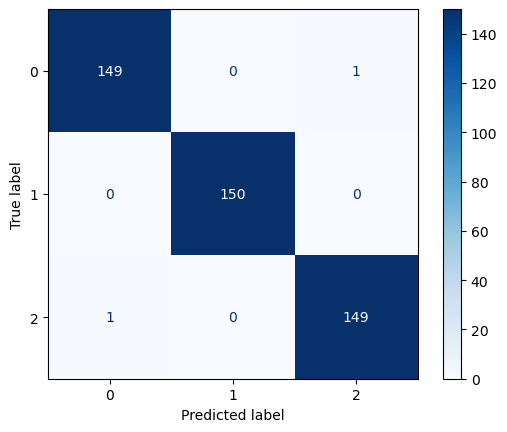

In [ ]:
# decision tree
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
clf2 = DecisionTreeClassifier(max_depth=3,random_state=42) 
clf2.fit(fx_train, y2_train)
y2_pred = clf2.predict(fx_test)
visualization(y2_test,y2_pred)

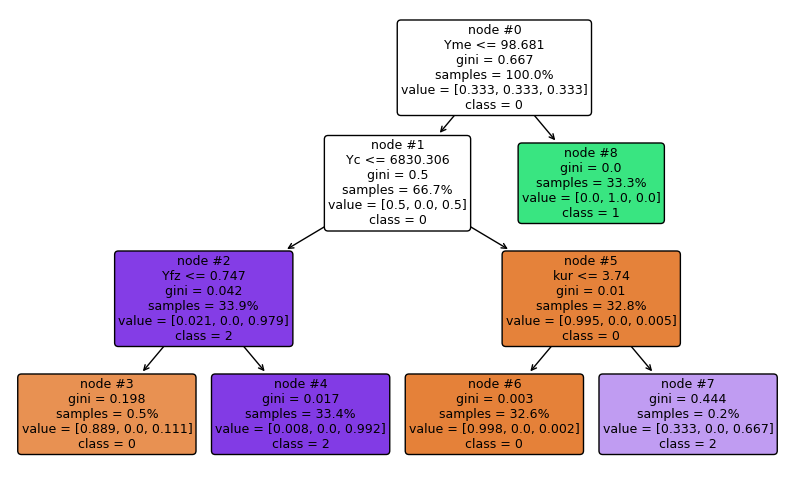

In [ ]:
# Plot the decision tree
fig, ax = plt.subplots(figsize=(10, 6))
_ = tree.plot_tree(
    clf2,
    feature_names=fx_train.columns.tolist(),  
    class_names=['0','1','2'],
    filled=True,
    ax=ax,
    proportion=True,
    node_ids=True,
    rounded=True
)
plt.show()

# Y1 NN
## CNN with FTT

In [ ]:
from keras.layers import Dense,Flatten,Conv1D,MaxPooling1D,AveragePooling1D,Dropout,LSTM,SimpleRNN,GRU,BatchNormalization

from keras.models import Sequential,load_model
from keras.optimizers import RMSprop

In [69]:
def my_fit(model):
    model.fit(fftx_train,y1_train,epochs=20,batch_size=50,validation_data=(fftx_test,y1_test))
    model.summary()

In [70]:
# cnn
model = Sequential()
input_dim = (1024,1)

model.add(Conv1D(8,3,activation="relu",input_shape=input_dim))
model.add(BatchNormalization())

model.add(Conv1D(32,5,activation="relu",padding='same'))
model.add(BatchNormalization())

model.add(Conv1D(64,5,activation="relu",padding='same'))
model.add(BatchNormalization())

model.add(Conv1D(128,7,activation="relu",padding='same'))
model.add(BatchNormalization())
model.add(AveragePooling1D(4))

model.add(Conv1D(512,9,activation="relu",padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling1D(4))

model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(512,activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(3,activation="softmax"))

model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
my_fit(model)

Epoch 1/20
36/36 [==============================] - 41s 1s/step - loss: 6.4950 - accuracy: 0.5194 - val_loss: 11.7353 - val_accuracy: 0.4200
Epoch 2/20
36/36 [==============================] - 36s 987ms/step - loss: 0.5923 - accuracy: 0.7583 - val_loss: 1.2759 - val_accuracy: 0.6644
Epoch 3/20
36/36 [==============================] - 36s 1s/step - loss: 0.4179 - accuracy: 0.8217 - val_loss: 0.9786 - val_accuracy: 0.6511
Epoch 4/20
36/36 [==============================] - 37s 1s/step - loss: 0.3950 - accuracy: 0.8389 - val_loss: 0.7850 - val_accuracy: 0.6467
Epoch 5/20
36/36 [==============================] - 36s 991ms/step - loss: 0.3156 - accuracy: 0.8650 - val_loss: 0.6261 - val_accuracy: 0.7378
Epoch 6/20
36/36 [==============================] - 36s 993ms/step - loss: 0.2679 - accuracy: 0.8761 - val_loss: 0.4980 - val_accuracy: 0.7822
Epoch 7/20
36/36 [==============================] - 36s 1s/step - loss: 0.2451 - accuracy: 0.8822 - val_loss: 0.4518 - val_accuracy: 0.7756
Epoch 8/20

In [ ]:
# model = load_model('Models/6_CNN_multi.h5')
# my_fit(model)
# model.save('6_CNN_multi.h5')

15/15 [==============================] - 2s 98ms/step
accuracy = 0.8933333333333333
f1 score = 0.8933333333333333


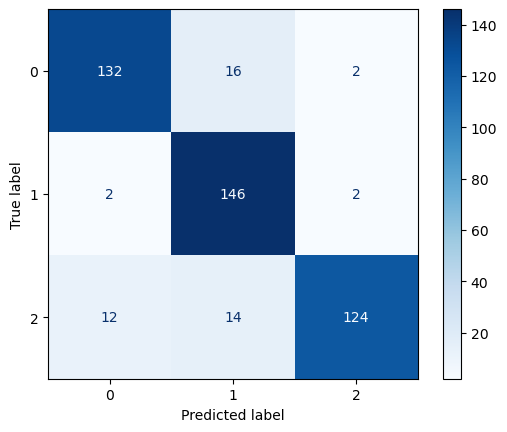

accuracy = 0.8888888888888888
f1 score = 0.8888888888888888


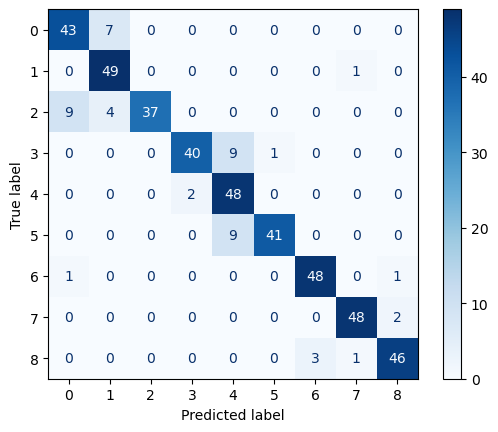

In [71]:
model_pred = model.predict(fftx_test)
y1_pred = np.argmax(model_pred,axis=1)
visualization(y1_test,y1_pred)
y_pred = combine_class(y1_pred,y2_pred)
visualization(y_test,y_pred)

In [ ]:
tmp = model_pred.max(axis=1)
tst = tmp.tolist()
for i in range(len(tmp)):
    if y1_test[i] != y1_pred[i]:
        print(i,y1_test[i],tmp[i],model_pred[i][y1_test[i]])
        # print(i,y1_test[i],model_pred[i][0],model_pred[i][1],model_pred[i][2])

14 0 0.9965485 0.0034506433
17 2 0.91610736 0.07694184
18 2 0.6696741 0.3273538
31 1 0.5662337 0.31807464
33 2 0.7148548 0.27627453
47 0 0.95443016 0.045569718
49 1 0.9224507 0.002783673
68 1 0.95372623 0.039740153
72 0 0.77609473 0.044887017
76 2 0.6445084 8.391004e-05
101 2 0.99763346 0.0023486582
103 2 0.8633665 0.01294033
105 0 0.9876688 0.010998462
107 0 0.6604513 0.33626765
113 0 0.5020184 0.022380881
114 0 0.8719169 0.12053094
120 1 0.91825104 0.0028247205
126 0 0.49433675 0.48178828
129 2 0.9154241 0.04530952
132 1 0.94817483 0.005841761
157 1 0.7864897 0.0019767587
177 2 0.9368883 0.0012232763
186 2 0.9601808 0.03800563
207 2 0.93272525 0.00087337353
224 2 0.9593453 0.040654738
227 0 0.99869907 0.0013005673
228 2 0.4848522 0.35325179
274 0 0.6965409 0.079746306
278 0 0.99949694 0.0005025709
296 2 0.8181196 0.07632079
302 2 0.8962568 0.09822497
307 1 0.9947049 0.0050888923
319 1 0.66153306 0.08479939
329 1 0.9906155 0.0019495438
331 1 0.57202095 0.42604795
334 2 0.98339003 0.00